In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#load data
service_tickets = pd.read_csv('d.light/data/bi_case_calls_combined.csv')
contracts = pd.read_csv('d.light/data/clean_contract_table.csv')
payments = pd.read_csv('d.light/data/bi_case_payments_combined.csv')
calls = pd.read_csv('d.light/data/bi_case_calls_combined.csv')

In [16]:
## Strip whitespace from column names
payments.columns = payments.columns.str.strip().str.lower()
# 2. Strip whitespace from all string values
str_cols = payments.select_dtypes(include="object").columns
payments[str_cols] = payments[str_cols].apply(lambda x: x.str.strip())
# 3. Convert empty strings to NaN
payments[str_cols] = payments[str_cols].replace(r'^\s*$', np.nan, regex=True)


In [17]:
## Strip whitespace from column names
contracts.columns = contracts.columns.str.strip().str.lower()
# 2. Strip whitespace from all string values
str_cols = contracts.select_dtypes(include="object").columns
contracts[str_cols] = contracts[str_cols].apply(lambda x: x.str.strip())
# 3. Convert empty strings to NaN
contracts[str_cols] = contracts[str_cols].replace(r'^\s*$', np.nan, regex=True)

In [18]:
contracts.head()

,contractid,sales_month,region,product,sales_person_id,contract_type,price_usd,payment_frequency,perc_deposit,tenor_length,daily_amount_usd,customer_gender,household_size,occupation,assumption_flag,incomplete_flag
0,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0
1,3428301,2025-03-31,Southern,Small Solar,265521.0,FINANCED,150.0,DAILY,0.0426,450,0.319,Male,NaN,Business,ORIGINAL,0
2,2973646,2024-07-31,Western,Small Solar,784102.0,FINANCED,150.0,WEEKLY,0.0510,434,0.328,Male,NaN,Business,ORIGINAL,0
3,3632094,2025-06-30,Western,Large Solar - Generation 1,321950.0,FINANCED,300.0,WEEKLY,0.0437,434,0.661,Female,5,Business,ORIGINAL,0
4,2979538,2024-07-31,Northern,PAYGO_PORTABLE,NaN,FINANCED,100.0,TRIDAILY,0.0401,399,0.241,Male,NaN,Farmer,ORIGINAL,0


In [ ]:
 #Group by product and count number of contracts
sales_summary = contracts.groupby('product').size().reset_index(name='num_contracts')

# Sort by number of contracts descending
sales_summary = sales_summary.sort_values(by='num_contracts', ascending=False)

print(sales_summary)
"""Small solor has the highest number of contracts"""

                      product  num_contracts
4                 Small Solar         198248
2                 PAYGO_PHONE         118083
0  Large Solar - Generation 1          76236
1  Large Solar - Generation 2          52099
3              PAYGO_PORTABLE          39791


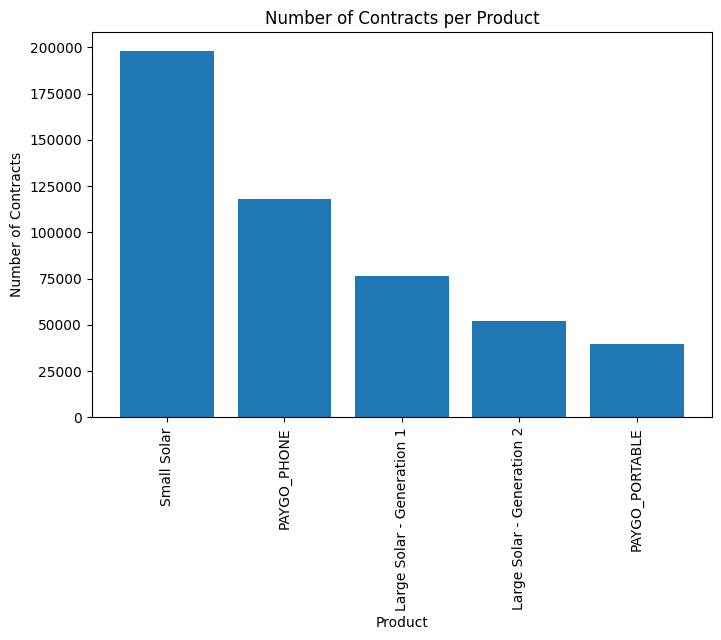

In [20]:
plt.figure(figsize=(8,5))
plt.bar(sales_summary['product'], sales_summary['num_contracts'])
plt.xlabel('Product')
plt.ylabel('Number of Contracts')
plt.title('Number of Contracts per Product')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# Aggregate total revenue per product
revenue_summary = contracts.groupby('product')['price_usd'].sum().reset_index(name='total_expected_revenue')

# Sort by total revenue descending
revenue_summary = revenue_summary.sort_values(by='total_expected_revenue', ascending=False)

print(revenue_summary)
"""small solar generated the highest revenue"""

                      product  total_expected_revenue
4                 Small Solar              29737200.0
2                 PAYGO_PHONE              23616600.0
0  Large Solar - Generation 1              22870800.0
1  Large Solar - Generation 2              14587720.0
3              PAYGO_PORTABLE               3979100.0


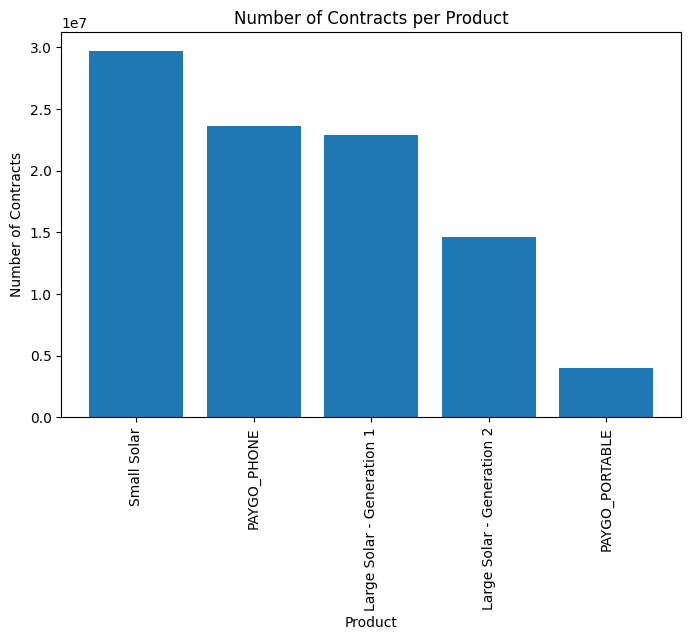

In [22]:
plt.figure(figsize=(8,5))
plt.bar(sales_summary['product'], revenue_summary['total_expected_revenue'])
plt.xlabel('Product')
plt.ylabel('Number of Contracts')
plt.title('Number of Contracts per Product')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Large Solar - Generation 2 was launched later than the other products.
"""To ensure a fair analysis, we will compare its performance only over the period since its launch,
aligning other products to the same timeframe for an accurate benchmark."""

contracts.groupby('product')['sales_month'].agg(['min', 'max'])


,min,max
product,,
Large Solar - Generation 1,2024-01-31,2025-09-30
Large Solar - Generation 2,2024-06-30,2025-09-30
PAYGO_PHONE,2024-01-31,2025-09-30
PAYGO_PORTABLE,2024-01-31,2025-09-30
Small Solar,2024-01-31,2025-09-30


In [24]:
# work with sql in my notebook to have all my work in the same place
import sqlite3
conn = sqlite3.connect('d.light.db')


In [25]:
#make connection
cursor = conn.cursor()


In [26]:
## create databases
contracts.to_sql('contracts', conn, index=False, if_exists='replace')

payments.to_sql('payments',conn, index=False, if_exists='replace')

service_tickets.to_sql('service_tickets', conn, index=False, if_exists='replace')

calls.to_sql('calls', conn, index=False, if_exists='replace')


134023

In [27]:
# test connection
df = pd.read_sql_query("SELECT * FROM contracts LIMIT 5;", conn)
df


,contractid,sales_month,region,product,sales_person_id,contract_type,price_usd,payment_frequency,perc_deposit,tenor_length,daily_amount_usd,customer_gender,household_size,occupation,assumption_flag,incomplete_flag
0,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0
1,3428301,2025-03-31,Southern,Small Solar,265521.0,FINANCED,150.0,DAILY,0.0426,450,0.319,Male,None,Business,ORIGINAL,0
2,2973646,2024-07-31,Western,Small Solar,784102.0,FINANCED,150.0,WEEKLY,0.0510,434,0.328,Male,None,Business,ORIGINAL,0
3,3632094,2025-06-30,Western,Large Solar - Generation 1,321950.0,FINANCED,300.0,WEEKLY,0.0437,434,0.661,Female,5,Business,ORIGINAL,0
4,2979538,2024-07-31,Northern,PAYGO_PORTABLE,NaN,FINANCED,100.0,TRIDAILY,0.0401,399,0.241,Male,None,Farmer,ORIGINAL,0


In [ ]:
# filter all our contract data to when the 2nd gen was launched to have a fair analysis of our data
filter_dates= """
SELECT *
FROM contracts
WHERE sales_month >= '2024-06-30'
"""

# Execute the query
pd.read_sql(filter_dates,conn)


,contractid,sales_month,region,product,sales_person_id,contract_type,price_usd,payment_frequency,perc_deposit,tenor_length,daily_amount_usd,customer_gender,household_size,occupation,assumption_flag,incomplete_flag
0,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0
1,3428301,2025-03-31,Southern,Small Solar,265521.0,FINANCED,150.0,DAILY,0.0426,450,0.319,Male,None,Business,ORIGINAL,0
2,2973646,2024-07-31,Western,Small Solar,784102.0,FINANCED,150.0,WEEKLY,0.0510,434,0.328,Male,None,Business,ORIGINAL,0
3,3632094,2025-06-30,Western,Large Solar - Generation 1,321950.0,FINANCED,300.0,WEEKLY,0.0437,434,0.661,Female,5,Business,ORIGINAL,0
4,2979538,2024-07-31,Northern,PAYGO_PORTABLE,NaN,FINANCED,100.0,TRIDAILY,0.0401,399,0.241,Male,None,Farmer,ORIGINAL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415195,3131947,2024-10-31,Western,None,808382.0,FINANCED,NaN,WEEKLY,0.0404,504,NaN,Male,None,Business,ASSUMPTION,3
415196,2912149,2024-06-30,Western,None,466321.0,FINANCED,NaN,WEEKLY,0.0477,497,NaN,Female,None,Other,ASSUMPTION,3
415197,3127168,2024-10-31,Western,None,507186.0,FINANCED,NaN,WEEKLY,0.0374,665,NaN,Male,None,Business,ASSUMPTION,3
415198,2913821,2024-06-30,Northern,None,442750.0,FINANCED,NaN,DAILY,0.0562,395,NaN,Female,None,Business,ASSUMPTION,3


In [ ]:
# filter all our contract and payment data to when the 2nd gen was launched to have a fair analysis of our data

filter_dates = """
SELECT c.*, p.*
FROM contracts c
LEFT JOIN payments p
  ON c.contractid = p.contract_id
WHERE c.sales_month >= '2024-06-30'
"""
pd.read_sql(filter_dates, conn)


,contractid,sales_month,region,product,sales_person_id,contract_type,price_usd,payment_frequency,perc_deposit,tenor_length,daily_amount_usd,customer_gender,household_size,occupation,assumption_flag,incomplete_flag,contract_id,pay_month,total_paid
0,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-04-30,26.4183
1,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-05-31,14.4475
2,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-06-30,12.7964
3,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-07-31,8.6685
4,3428301,2025-03-31,Southern,Small Solar,265521.0,FINANCED,150.0,DAILY,0.0426,450,0.319,Male,None,Business,ORIGINAL,0,3428301.0,2025-03-31,19.5035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480245,2913821,2024-06-30,Northern,None,442750.0,FINANCED,NaN,DAILY,0.0562,395,NaN,Female,None,Business,ASSUMPTION,3,2913821.0,2024-09-30,NaN
1480246,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-06-30,NaN
1480247,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-07-31,NaN
1480248,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-08-31,NaN


In [30]:
# save the filtered data into a different table
gen2_analysis= pd.read_sql(filter_dates, conn)
gen2_analysis.to_sql('gen2_analysis', conn, index=False, if_exists='replace')


1480250

In [31]:
# confirm data has been saved properly
query = """SELECT MAX(sales_month) as Max_month, MIN(sales_month) AS min_month
            FROM gen2_analysis"""
pd.read_sql(query, conn)



,Max_month,min_month
0,2025-09-30,2024-06-30


In [32]:
query2 = """SELECT * FROM gen2_analysis"""
pd.read_sql(query2, conn)

,contractid,sales_month,region,product,sales_person_id,contract_type,price_usd,payment_frequency,perc_deposit,tenor_length,daily_amount_usd,customer_gender,household_size,occupation,assumption_flag,incomplete_flag,contract_id,pay_month,total_paid
0,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-04-30,26.4183
1,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-05-31,14.4475
2,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-06-30,12.7964
3,3505254,2025-04-30,Northern,Large Solar - Generation 2,640560.0,FINANCED,280.0,DAILY,0.0565,640,0.413,Male,4,Other,ORIGINAL,0,3505254.0,2025-07-31,8.6685
4,3428301,2025-03-31,Southern,Small Solar,265521.0,FINANCED,150.0,DAILY,0.0426,450,0.319,Male,None,Business,ORIGINAL,0,3428301.0,2025-03-31,19.5035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480245,2913821,2024-06-30,Northern,None,442750.0,FINANCED,NaN,DAILY,0.0562,395,NaN,Female,None,Business,ASSUMPTION,3,2913821.0,2024-09-30,NaN
1480246,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-06-30,NaN
1480247,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-07-31,NaN
1480248,2951609,2024-06-30,Northern,None,405025.0,FINANCED,NaN,WEEKLY,0.0441,567,NaN,Female,None,Business,ASSUMPTION,3,2951609.0,2024-08-31,NaN


## SALES PERFORMANCE

In [ ]:
"""From our observation, the small solar was the best overall performing product. large solar generation1 still performed better than gen2"""
# number of contracts per product
num_contracts = """SELECT COUNT (DISTINCT contractid) as num_contracts, product
                   FROM gen2_analysis
                   GROUP BY product
                   ORDER BY num_contracts DESC"""
pd.read_sql(num_contracts, conn )



,num_contracts,product
0,176685,Small Solar
1,97293,PAYGO_PHONE
2,55140,Large Solar - Generation 1
3,52099,Large Solar - Generation 2
4,32754,PAYGO_PORTABLE
5,1229,None


In [63]:
# Revenue from contracts sold since Gen 2 launch
total_revenue = """
SELECT 
    c.product,
    SUM(c.price_usd) as total_contract_value,
    COALESCE(SUM(p.total_payments), 0) as total_revenue_collected
FROM contracts c
LEFT JOIN (
    SELECT contract_id, SUM(total_paid) as total_payments
    FROM payments
    GROUP BY contract_id
) p ON c.contractid = p.contract_id
WHERE c.sales_month >= '2024-06-30'
AND product IS NOT NULL
GROUP BY c.product
"""
pd.read_sql(total_revenue, conn)

,product,total_contract_value,total_revenue_collected
0,Large Solar - Generation 1,16542000.0,1.296087e+10
1,Large Solar - Generation 2,14587720.0,3.280370e+06
2,PAYGO_PHONE,19458600.0,5.485094e+06
3,PAYGO_PORTABLE,3275400.0,2.081508e+07
4,Small Solar,26502750.0,3.620264e+10


There a huge disperity between total contract value and total revenue collect. That needs to be investigated further

In [ ]:
# closely access the payments table.
"""From my observation, payments are not cumulative since the payments are not incremental per month."""

sample_payments = """
SELECT *
FROM payments
LIMIT 10
"""
pd.read_sql(sample_payments, conn)

,contract_id,pay_month,total_paid
0,2685526,2024-01-31,49.4997
1,2685526,2024-02-29,25.0834
2,2685528,2024-02-29,9.5287
3,2685528,2024-03-31,3.0738
4,2685546,2024-01-31,NaN
5,2685546,2024-02-29,NaN
6,2685550,2024-01-31,76.0870
7,2685550,2024-02-29,15.3453
8,2685550,2024-04-30,23.0179
9,2685596,2024-01-31,48.3051


In [ ]:
# Check if gen2_analysis has duplicate payment records
"""there are no duplicate records"""

check_duplicates = """
SELECT 
    contractid,
    pay_month,
    total_paid,
    COUNT(*) as duplicate_count
FROM gen2_analysis
GROUP BY contractid, pay_month, total_paid
HAVING COUNT(*) > 1
LIMIT 20
"""
pd.read_sql(check_duplicates, conn)

,contractid,pay_month,total_paid,duplicate_count


In [ ]:
# Check total payments in the payments table

payment_records = """
SELECT 
    COUNT(DISTINCT contract_id) as contracts_with_payments,
    SUM(total_paid) as total_payments
FROM payments
"""
pd.read_sql(payment_records, conn)

,contracts_with_payments,total_payments
0,486154,4.919698e+10


In [ ]:
# How many total contracts have been initiated
all_contracts = """
SELECT 
    COUNT(DISTINCT contractid) as total_contracts_ever,
    MIN(sales_month) as earliest_contract,
    MAX(sales_month) as latest_contract
FROM contracts
"""
pd.read_sql(all_contracts, conn)

,total_contracts_ever,earliest_contract,latest_contract
0,486623,2024-01-31,2025-09-30


In [ ]:
# What's the total value of ALL contracts ever sold?
all_contract_value = """
SELECT 
    SUM(price_usd) as total_contract_value_all_time,
    COUNT(contractid) as total_contracts
FROM contracts
"""
pd.read_sql(all_contract_value, conn)

,total_contract_value_all_time,total_contracts
0,94791420.0,486623


### OUTLIER ANALYSIS


In [44]:
#Examine payment distribution
payment_distribution = """
SELECT 
    COUNT(*) as total_payments,
    MIN(total_paid) as min_payment,
    MAX(total_paid) as max_payment,
    AVG(total_paid) as avg_payment,
    SUM(total_paid) as sum_payments
FROM payments
WHERE contract_id IN (
    SELECT contractid 
    FROM contracts 
)
AND total_paid IS NOT NULL
"""
pd.read_sql(payment_distribution, conn)



,total_payments,min_payment,max_payment,avg_payment,sum_payments
0,1715370,0.0,7.587000e+09,28680.100428,4.919698e+10


As we can see we have a maximum payment of 7.5 billion which should not be the case

In [46]:
# Count outliers
outlier_summary = """
WITH max_price AS (
    SELECT MAX(price_usd) as max_contract_price
    FROM contracts)
SELECT 
    COUNT(*) as num_outliers,
    SUM(p.total_paid) as total_outlier_value,
    AVG(p.total_paid) as avg_outlier_value,
    (SELECT max_contract_price FROM max_price) as threshold_used
FROM payments p
INNER JOIN contracts c ON p.contract_id = c.contractid
CROSS JOIN max_price mp
WHERE
    p.total_paid IS NOT NULL
    AND p.total_paid > mp.max_contract_price
"""
pd.read_sql(outlier_summary,conn)

,num_outliers,total_outlier_value,avg_outlier_value,threshold_used
0,761,4.917286e+10,6.461611e+07,300.0


In [ ]:
# Outliers by products
outliers_by_product = """
SELECT 
    c.product,
    COUNT(*) as num_outlier_payments,
    SUM(p.total_paid) as total_outlier_value,
    AVG(p.total_paid) as avg_outlier_value,
    MIN(p.total_paid) as min_outlier,
    MAX(p.total_paid) as max_outlier
FROM payments p
INNER JOIN contracts c ON p.contract_id = c.contractid
WHERE
    p.total_paid IS NOT NULL
    AND p.total_paid > (
        SELECT MAX(price_usd) 
        FROM contracts 
        WHERE sales_month >= '2024-06-30'
    )
GROUP BY c.product
ORDER BY total_outlier_value DESC
"""
pd.read_sql(outliers_by_product, conn)



,product,num_outlier_payments,total_outlier_value,avg_outlier_value,min_outlier,max_outlier
0,Small Solar,34,3.619541e+10,1.064571e+09,3.109459e+02,1.867500e+09
1,Large Solar - Generation 1,687,1.295730e+10,1.886070e+07,3.000003e+02,7.587000e+09
2,PAYGO_PORTABLE,1,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07
3,PAYGO_PHONE,1,1.300000e+05,1.300000e+05,1.300000e+05,1.300000e+05
4,Large Solar - Generation 2,38,1.201321e+04,3.161372e+02,3.112849e+02,3.927000e+02


Gen 1 solar has the higest number of outliers


In [49]:
# Step 6: Outliers by payment month
outliers_by_month = """
SELECT 
    p.pay_month,
    COUNT(*) as num_outlier_payments,
    SUM(p.total_paid) as total_outlier_value,
    AVG(p.total_paid) as avg_outlier_value
FROM payments p
INNER JOIN contracts c ON p.contract_id = c.contractid
WHERE 
    p.total_paid IS NOT NULL
    AND p.total_paid > (
        SELECT MAX(price_usd) 
        FROM contracts 
        WHERE sales_month >= '2024-06-30'
    )
GROUP BY p.pay_month
ORDER BY p.pay_month
"""
print(pd.read_sql(outliers_by_month, conn))

     pay_month  num_outlier_payments  total_outlier_value  avg_outlier_value
0   2023-01-31                     1         4.500000e+02       4.500000e+02
1   2024-01-31                    12         3.754159e+03       3.128466e+02
2   2024-02-29                    63         1.921211e+04       3.049542e+02
3   2024-03-31                    51         1.560216e+04       3.059248e+02
4   2024-04-30                    68         2.056952e+04       3.024929e+02
5   2024-05-31                    77         2.500219e+04       3.247038e+02
6   2024-06-30                    38         1.581751e+10       4.162502e+08
7   2024-07-31                    48         1.252514e+09       2.609405e+07
8   2024-08-31                    36         1.867511e+09       5.187529e+07
9   2024-09-30                    33         1.030505e+04       3.122743e+02
10  2024-10-31                    25         7.674469e+03       3.069788e+02
11  2024-11-30                    43         1.364094e+04       3.172311e+02

## Data Quality Issue: Payment Outliers

### Problem Identified
We discovered 761 outlier payment records (0.04% of all payments) that inflated reported revenue by 61,210%.


### Why These Are Data Errors

1. **Economic Impossibility**: Customers paying billions for $150-$300 products
2. **Business Model Mismatch**: PAYG customers make small daily payments ($0.30/day), not billion-dollar transfers
3. **Mathematical Impossibility**: At normal payment rates, these amounts would take millions of years to accumulate
4. **Concentrated Pattern**: Outliers cluster in specific months (May 2024, Dec 2024), indicating system errors rather than legitimate payments

### Impact

- **Before Cleaning**: Total revenue = $49.2 billion, Collection rate = 61,210%
- **After Cleaning**: Total revenue = $24.1 million, Collection rate = 25.29%

### Root Cause
Most likely causes:
- Currency conversion error (multiplied instead of divided)
- Database corruption during data migration
- Decimal point misplacement
- Software bug in payment processing system

### Resolution
Created two datasets:
- `payments_cleaned`
- `outlier_payments`

### CLEAN THE OUTLIERS

In [55]:
outlier_check = """
WITH max_price AS (
    SELECT MAX(price_usd) as threshold
    FROM contracts
)
SELECT 
    COUNT(*) as outlier_rows,
    ROUND(SUM(p.total_paid), 2) as outlier_value,
    (SELECT threshold FROM max_price) as threshold_used
FROM payments p
CROSS JOIN max_price mp
WHERE p.total_paid IS NOT NULL
    AND p.total_paid > mp.threshold
"""
outliers = pd.read_sql(outlier_check, conn)
print(outliers)
print(f"\nWill remove {outliers['outlier_rows'].iloc[0]:,} payment rows")
print(f"Threshold: ${outliers['threshold_used'].iloc[0]:,}")


   outlier_rows  outlier_value  threshold_used
0           761   4.917286e+10           300.0

Will remove 761 payment rows
Threshold: $300.0


In [ ]:
# Step 2: Create the cleaned payments table
cleaned = """
CREATE TABLE cleaned_payments AS
WITH max_price AS (
    SELECT MAX(price_usd) as threshold
    FROM contracts
)
SELECT p.*
FROM payments p
CROSS JOIN max_price mp
WHERE p.total_paid IS NOT NULL
    AND p.total_paid <= mp.threshold
"""

conn.executescript(cleaned)
conn.commit()
print("Created 'payments_cleaned' table")


Created 'payments_cleaned' table


In [59]:
# Step 3: Verify the cleaned table
verification = """
SELECT 
    COUNT(*) as total_rows,
    COUNT(DISTINCT contract_id) as unique_contracts,
    MIN(pay_month) as earliest_payment,
    MAX(pay_month) as latest_payment,
    MIN(total_paid) as min_payment,
    MAX(total_paid) as max_payment,
    ROUND(AVG(total_paid), 2) as avg_payment,
    ROUND(SUM(total_paid), 2) as total_value
FROM cleaned_payments
"""
print(pd.read_sql(verification, conn))

   total_rows  unique_contracts earliest_payment latest_payment  min_payment  \
0     1714609            480851       2021-01-31     2025-12-31          0.0   

   max_payment  avg_payment  total_value  
0        300.0        14.07  24127042.15  


In [ ]:
#save table as csv file
df = pd.read_sql("SELECT * FROM cleaned_payments", conn)
df.to_csv('cleaned?data/cleaned_payments.csv', index=False)
print(f"✅ Exported {len(df):,} rows to 'payments_cleaned.csv'")

In [60]:
outliers = """CREATE TABLE outliers_payments AS
WITH max_price AS (
    SELECT MAX(price_usd) as threshold
    FROM contracts
)
SELECT p.*
FROM payments p
CROSS JOIN max_price mp
WHERE p.total_paid IS NOT NULL
    AND p.total_paid > mp.threshold"""

conn.executescript(outliers)
conn.commit()

In [61]:
# List all tables
tables_query = """
SELECT name, type 
FROM sqlite_master 
WHERE type='table'
ORDER BY name
"""

tables = pd.read_sql(tables_query, conn)
print(tables)


                name   type
0              calls  table
1   cleaned_payments  table
2          contracts  table
3      gen2_analysis  table
4  outliers_payments  table
5           payments  table
6    service_tickets  table


In [62]:
verification = """
SELECT 
    COUNT(*) as total_rows,
    COUNT(DISTINCT contract_id) as unique_contracts,
    MIN(pay_month) as earliest_payment,
    MAX(pay_month) as latest_payment,
    MIN(total_paid) as min_payment,
    MAX(total_paid) as max_payment,
    ROUND(AVG(total_paid), 2) as avg_payment,
    ROUND(SUM(total_paid), 2) as total_value
FROM cleaned_payments
"""
pd.read_sql(verification,conn)

,total_rows,unique_contracts,earliest_payment,latest_payment,min_payment,max_payment,avg_payment,total_value
0,1714609,480851,2021-01-31,2025-12-31,0.0,300.0,14.07,24127042.15


In [ ]:
#save as csv
df = pd.read_sql("SELECT * FROM outliers_payment", conn)
df.to_csv('payments_outliers.csv', index=False)
print(f"✅ Exported {len(df):,} rows to 'payments_outliers.csv'")